# Construction de Psi

## Librairies

In [11]:
from kymatio.numpy import Scattering1D
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
from maad.features import tfsd
from maad.sound import spectrogram
from maad.util import plot2d, power2dB, plot_spectrogram
import os
import h5py

## Pour JobLib

In [2]:
from joblib import Memory
import time

cachedir = './joblib_cache'
memory = Memory(cachedir)

## Construction

### Outils

In [3]:
# Function to get the sound with filename
def getSound(filename, duration):
    fe, sound = wavfile.read(filename)
    nbSamples = round(fe * duration)
    sound = sound[0:nbSamples]
    return sound, fe

# Function to get the sound with position
def getSoundAtPosition(root, position):
    return getSound(getFilenameAtPosition(root, position), duration)
    
# Function to get the filename with position
def getFilenameAtPosition(root, position):
    for root, dirnames, filenames in os.walk(root):
        f = filenames[position]
        filename = os.path.join(root, f)
        return filename
    
# Display the spectrogram of a sound
def displaySpectrogram(sound, fe, title, ax):
    
    spec, tn, fn, ext = spectrogram(sound, fe)   
    spec_dB = power2dB(spec)

    fig_kwargs = {'vmax': spec_dB.max(),'vmin':-70,'extent':ext,'title':title,'xlabel':'Time [sec]','ylabel':'Frequency [Hz]'}

    plot2d(spec_dB,**fig_kwargs, ax = ax, colorbar = False, now = False)

### Pertinence

In [4]:
def compute_pertinence(sound, fe):
    Spec, tn, fn, _ = spectrogram(sound, fe)
    q = tfsd(Spec, fn, tn)
    return np.sqrt(q)

### Descripteur

In [5]:
def compute_descriptor(sound, J, Q):
    
    T = sound.shape[-1]

    scattering = Scattering1D(J, T, Q)

    scalogram = scattering(sound / np.max(np.abs(sound)))

    order2 = np.where(scattering.meta()['order'] == 2)

    descriptor = scalogram[order2]
    descriptor = np.mean(descriptor, axis=1)
    descriptor = descriptor / np.linalg.norm(descriptor)

    return descriptor

### PSI

In [15]:
# Valeur maximale de nbSounds : 432
def compute_PSI(root, J, Q, duration, nbSounds):
    
    psi = [0] * nbSounds
    
    k = 0
    progress = -1
    for root, dirnames, filenames in os.walk(root):
        for f in filenames:
            
            if k >= nbSounds:
                break
                
            percentage = round(k/nbSounds * 100)
            if (percentage % 10) == 0 and percentage > progress:
                progress = percentage
                print(percentage, "%")
                
            filename = os.path.join(root, f)
            
            sound, fe = getSound(filename, duration)
            q = compute_pertinence(sound, fe)
            d = compute_descriptor(sound, J, Q)
            psi[k] = q*d
            k += 1
            
    print("DONE")
    
    return np.array(psi)

## Tri par pertinence

In [7]:
root = './SoundDatabase'
nbSounds = 432
duration = 5

q = {}

k = 0
for root, dirnames, filenames in os.walk(root):
        for f in filenames:
            
            filename = os.path.join(root, f)
            sound, fe = getSound(filename, duration)
            q[k] = compute_pertinence(sound, fe)
            k += 1
        
q = dict(sorted(q.items(), key = lambda x: x[1]))

MORE PERTINENT SOUNDS


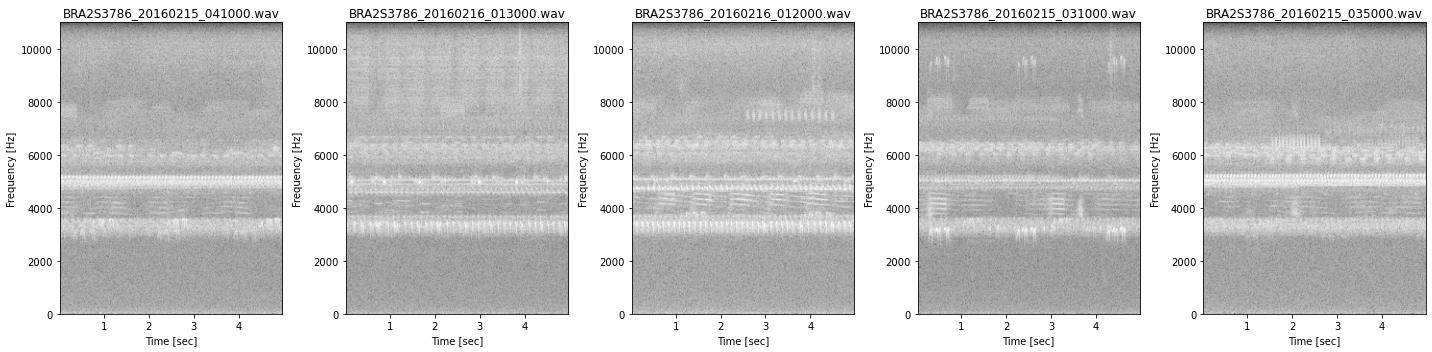

LEAST PERTINENT SOUNDS


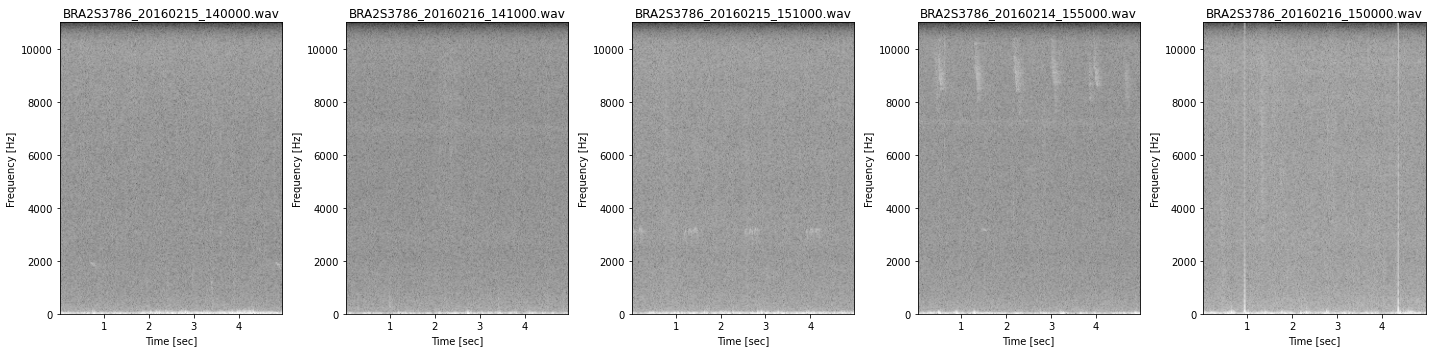

In [8]:
root = './SoundDatabase'
best5 = list(q.items())[-5:]
best5 = [best5[k][0] for k in range(5)]
worse5 = list(q.items())[:5]
worse5 = [worse5[k][0] for k in range(5)]


print("MORE PERTINENT SOUNDS")

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for k in range(5):
    sound, fe = getSoundAtPosition(root, best5[k])
    title = getFilenameAtPosition(root, best5[k])[(len(root) + 1):]
    
    displaySpectrogram(sound, fe, title, ax[k])

plt.show()


print("LEAST PERTINENT SOUNDS")

fig, ax = plt.subplots(1, 5, figsize=(20,5))
for k in range(5):
    sound, fe = getSoundAtPosition(root, worse5[k])
    title = getFilenameAtPosition(root, worse5[k])[(len(root) + 1):]
    displaySpectrogram(sound, fe, title, ax[k])
    
plt.show()

## TEST

(69,)


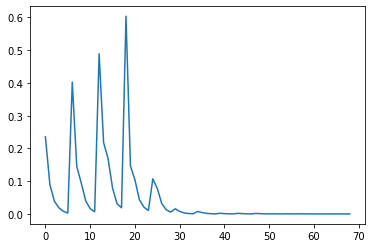

In [9]:
s, fe = getSound("./SoundDatabase/BRA2S3786_20160214_000000.wav", 1)
J, Q = 8, 3

d = compute_descriptor(s, J, Q)

print(d.shape)
plt.plot(d)
plt.show()

In [25]:
# persiste psi to h5py file

persisted_psi = h5py.File("./persisted_data/psi.hdf5", "a") # append mode : create file if it doesnt exist

if 'psi_1' in persisted_psi:
    print("loading psi from persisted file")
    psi = persisted_psi['psi_1'][:]
else:
    print("creating psi and persisting it to a file")
    J, Q = 8, 3
    psi = compute_PSI('./SoundDatabase', J, Q, 5, 432) 
    persisted_psi.create_dataset('psi_1', data=psi)

persisted_psi.close()

loading psi from persisted file


(432, 69)


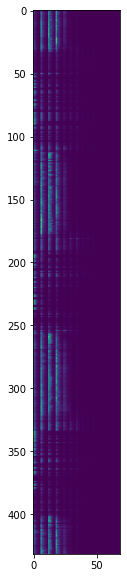

In [26]:
print(psi.shape)
fig = plt.figure(figsize=(5, 10))
plt.imshow(psi)
plt.show()